In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming df has been defined and loaded with your data earlier



import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
# prompt: read all the csv files "D:\OneDrive - The Pennsylvania State University\Research DATA\Dr. Habib & Dr. Reza Data\Energy Price Market Data\Day Ahead Price Data_Processed\USA\NYISO" and merge into a one dataframe df

folder_path = r"D:\OneDrive - The Pennsylvania State University\Research DATA\Dr. Habib & Dr. Reza Data\Energy Price Market Data\Day Ahead Price Data_Processed\USA\NYISO"

all_nyiso_data = pd.DataFrame()

for root, dirs, files in os.walk(folder_path):
    for file in files:
        if file.endswith('.csv'):
            file_path = os.path.join(root, file)
            try:
                df_temp = pd.read_csv(file_path)
                all_nyiso_data = pd.concat([all_nyiso_data, df_temp], ignore_index=True)
            except Exception as e:
                print(f"Error reading file {file_path}: {e}")

df = all_nyiso_data.copy() # Assign the concatenated dataframe to df
print(df)

               Timestamp  CAPITL  CENTRL  DUNWOD  GENESE    H Q  HUD VL  \
0       01/01/2000 00:00   42.88   39.49   43.70   38.98  39.98   42.92   
1       01/01/2000 01:00   41.55   38.26   42.34   37.77  38.74   41.58   
2       01/01/2000 02:00   40.98   37.74   41.76   37.25  38.20   41.01   
3       01/01/2000 03:00   36.59   33.69   37.28   33.26  34.11   36.62   
4       01/01/2000 04:00   42.88   39.49   43.70   38.98  39.98   42.92   
...                  ...     ...     ...     ...     ...    ...     ...   
222857  06/04/2025 19:00   59.72   57.66   60.76   56.99  55.75   60.25   
222858  06/04/2025 20:00   58.57   57.73   59.75   57.56  55.74   59.41   
222859  06/04/2025 21:00   50.16   48.17   49.49   47.88  47.53   49.30   
222860  06/04/2025 22:00   41.36   40.40   42.16   40.00  39.93   41.84   
222861  06/04/2025 23:00   36.23   35.46   37.07   35.39  34.70   36.89   

        LONGIL  MHK VL  MILLWD  N.Y.C.  NORTH    NPX    O H    PJM   WEST  
0        43.72   41.15 

In [3]:
df.head()

,Timestamp,CAPITL,CENTRL,DUNWOD,GENESE,H Q,HUD VL,LONGIL,MHK VL,MILLWD,N.Y.C.,NORTH,NPX,O H,PJM,WEST
0,01/01/2000 00:00,42.88,39.49,43.70,38.98,39.98,42.92,43.72,41.15,43.08,44.52,40.03,42.04,37.68,38.52,37.49
1,01/01/2000 01:00,41.55,38.26,42.34,37.77,38.74,41.58,42.35,39.86,41.74,43.40,38.79,40.73,36.51,37.32,36.32
2,01/01/2000 02:00,40.98,37.74,41.76,37.25,38.20,41.01,40.88,39.32,41.17,43.18,38.25,40.17,36.01,36.81,35.82
3,01/01/2000 03:00,36.59,33.69,37.28,33.26,34.11,36.62,37.90,35.10,36.75,40.83,34.15,35.86,32.15,32.86,31.98
4,01/01/2000 04:00,42.88,39.49,43.70,38.98,39.98,42.92,41.00,41.15,43.08,44.52,40.03,42.04,37.68,38.52,37.49


In [4]:
# Data Preprocessing
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['CAPITL'].values.reshape(-1,1))


# Creating a data structure with 60 timesteps and 1 output
X, y = [], []
for i in range(60, len(scaled_data)):
    X.append(scaled_data[i-60:i, 0])
    y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)

# Splitting the data into training and testing sets based on the year
train_df = df[df.index < "2023-01-01"]
test_df = df[df.index >= "2023-01-01"]

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("Train years:", train_df.index.year.unique())
print("Test years:", test_df.index.year.unique())



train_scaled = scaler.transform(train_df['CAPITL'].values.reshape(-1,1))
test_scaled = scaler.transform(test_df['CAPITL'].values.reshape(-1,1))

Train shape: (201601, 15)
Test shape: (21261, 15)
Train years: Index([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
      dtype='int32', name='Timestamp')
Test years: Index([2023, 2024, 2025], dtype='int32', name='Timestamp')


Epoch 1/2
6299/6299 ━━━━━━━━━━━━━━━━━━━━ 3043s 466ms/step - loss: 0.0056 - val_loss: 1.2799e-04
Epoch 2/2
6299/6299 ━━━━━━━━━━━━━━━━━━━━ 1929s 306ms/step - loss: 1.0448e-04 - val_loss: 9.8951e-05
663/663 ━━━━━━━━━━━━━━━━━━━━ 64s 94ms/step
Transformer Model Evaluation Metrics:
MAE: 6.275844993816672
RMSE: 12.915151849283495
sMAPE: 13.081096427817288%
R^2: 0.8773240595009164


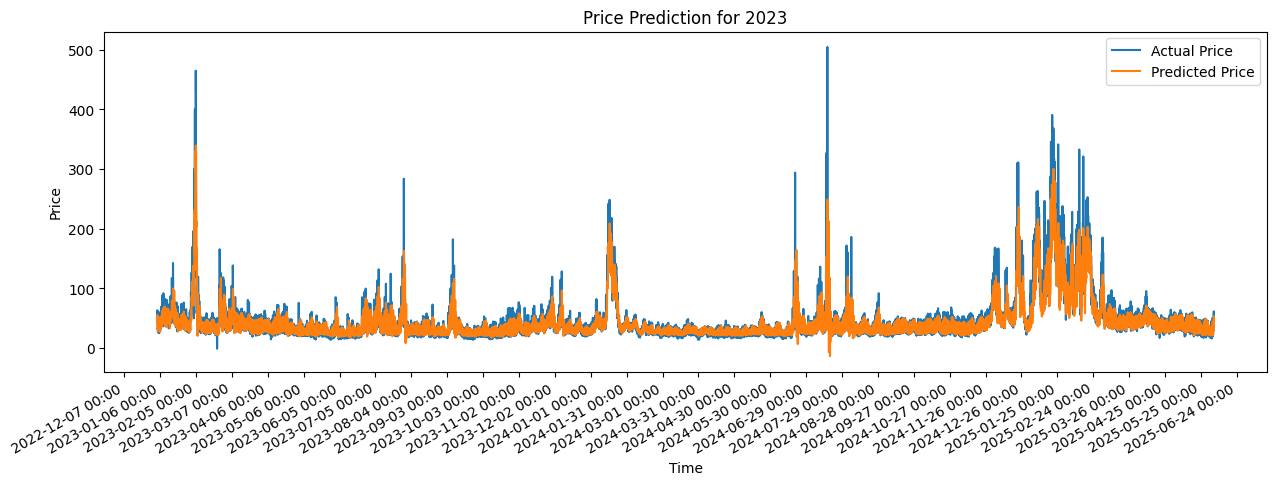

In [5]:


X_train, y_train, X_test, y_test = [], [], [], []
for i in range(60, len(train_scaled)):
    X_train.append(train_scaled[i-60:i, 0])
    y_train.append(train_scaled[i, 0])
for i in range(60, len(test_scaled)):
    X_test.append(test_scaled[i-60:i, 0])
    y_test.append(test_scaled[i, 0])
X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

# Reshaping for the Transformer model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Transformer model definition
# Include positional_encoding and transformer_encoder functions as defined

def positional_encoding(positions, d_model):
    angle_rates = 1 / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
    angle_rads = np.arange(positions)[:, np.newaxis] * angle_rates
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res

# Model building
def build_transformer(time_steps, features, head_size=256, num_heads=4, ff_dim=4, num_transformer_blocks=4, mlp_units=[128], dropout=0.1, mlp_dropout=0.1):
    inputs = Input(shape=(time_steps, features))
    x = inputs + positional_encoding(time_steps, features)
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = GlobalAveragePooling1D(data_format="channels_first")(x)
    for units in mlp_units:
        x = Dense(units, activation="relu")(x)
        x = Dropout(mlp_dropout)(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    return model

# Adjust the parameters based on your dataset specifics
model = build_transformer(
    time_steps=X_train.shape[1],
    features=X_train.shape[2],
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    dropout=0.1,
    mlp_dropout=0.1
)

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_squared_error')

# Fit the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=2,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

# Predictions
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

# Evaluation
test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
mse = mean_squared_error(test_actual, predicted_prices)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_actual, predicted_prices)
r2 = r2_score(test_actual, predicted_prices)

def calculate_smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0  # handle the case where both prediction and actual are zero
    return 100 * np.mean(diff)

smape = calculate_smape(test_actual, predicted_prices)

print(f"Transformer Model Evaluation Metrics:\nMAE: {mae}\nRMSE: {rmse}\nsMAPE: {smape}%\nR^2: {r2}")

# Visualization
test_df_index_truncated = test_df.index[60:]  # Adjust to match the length of predictions
plt.figure(figsize=(15, 5))
plt.plot(test_df_index_truncated, test_actual, label='Actual Price')
plt.plot(test_df_index_truncated, predicted_prices, label='Predicted Price')
plt.title('Price Prediction for 2023')
plt.xlabel('Time')
plt.ylabel('Price')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gcf().autofmt_xdate()

plt.legend()
plt.show()


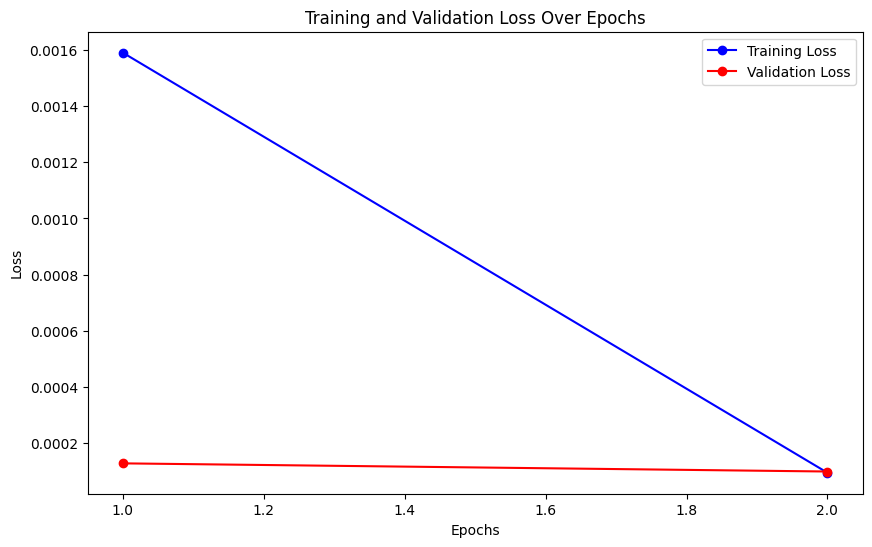

In [6]:
import matplotlib.pyplot as plt

# Extract loss values from the history object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

# Plotting Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, 'bo-', label='Training Loss')
plt.plot(epochs, validation_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


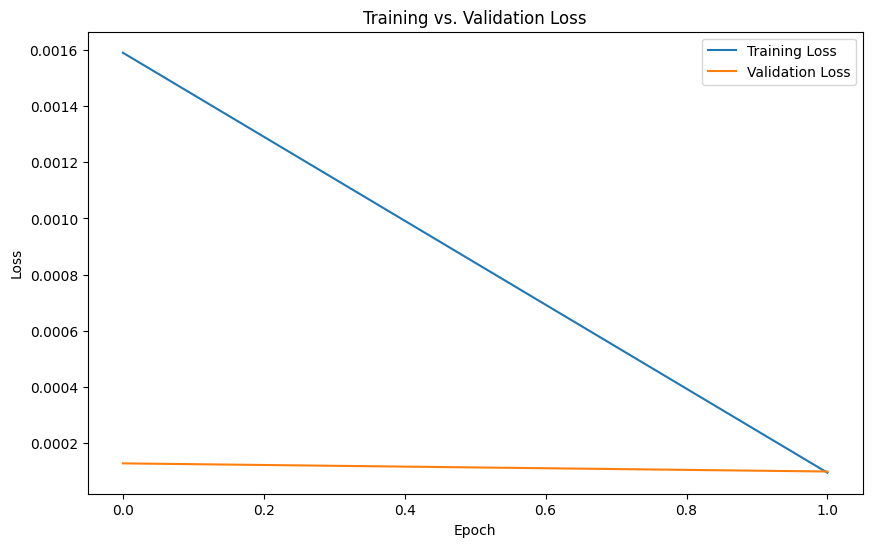

In [7]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


663/663 ━━━━━━━━━━━━━━━━━━━━ 58s 87ms/step


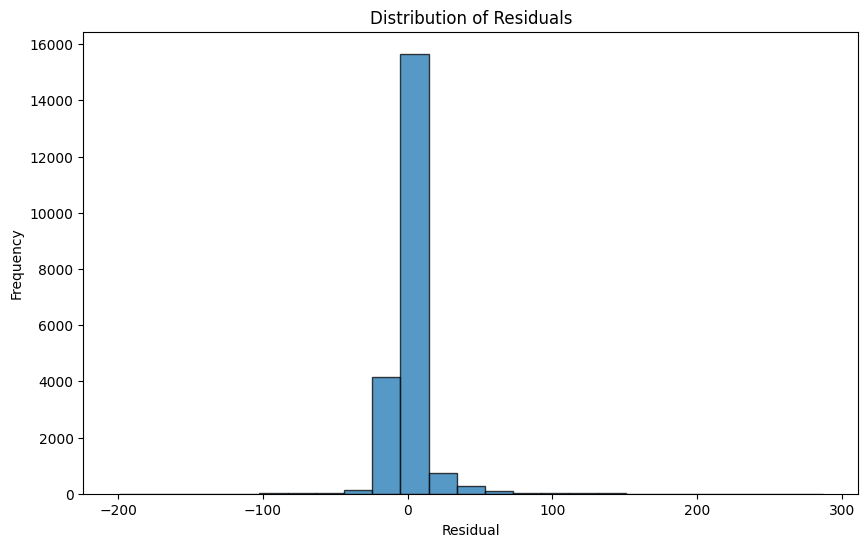

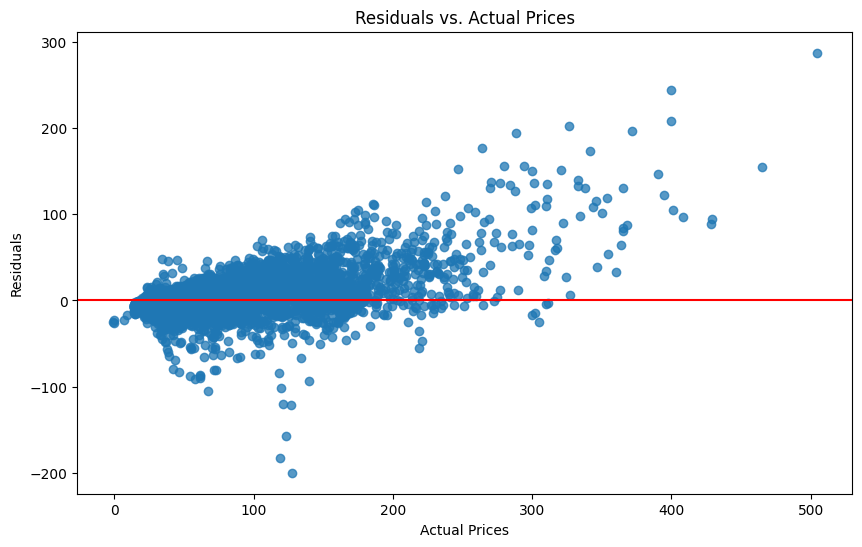

In [8]:
# Predictions
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)
test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate residuals
residuals = test_actual - predicted_prices

# Plotting residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=25, alpha=0.75, edgecolor='black')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

# Scatter plot of residuals
plt.figure(figsize=(10, 6))
plt.scatter(x=test_actual, y=residuals, alpha=0.75)
plt.xlabel('Actual Prices')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residuals vs. Actual Prices')
plt.show()


In [9]:
from sklearn.metrics import r2_score

r2 = r2_score(test_actual, predicted_prices)
print(f'R2 Score: {r2:.4f}')


R2 Score: 0.8773


In [10]:
from sklearn.metrics import r2_score

def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0  # Filter out zero values to avoid division by zero
    y_true_filtered, y_pred_filtered = y_true[non_zero_indices], y_pred[non_zero_indices]
    mape = np.mean(np.abs((y_true_filtered - y_pred_filtered) / y_true_filtered)) * 100
    return mape

def calculate_r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

# Assuming you have test_actual and predicted_prices from your previous code
mape_value = calculate_mape(test_actual, predicted_prices)
r2_value = calculate_r2(test_actual, predicted_prices)

print(f"MAPE: {mape_value}%")
print(f"R-squared Value: {r2_value}")


MAPE: 13.932025081284753%
R-squared Value: 0.8773240595009164


In [11]:
# Create a DataFrame for the predicted values
predicted_df = pd.DataFrame(predicted_prices, index=test_df_index_truncated, columns=['Predicted'])

# Since test_actual_truncated is a NumPy array, convert it back to a DataFrame
actual_df = pd.DataFrame(test_actual_truncated, index=test_df_index_truncated, columns=['Actual'])

# # Combine actual and predicted values into a single DataFrame for comparison
comparison_df = pd.concat([actual_df, predicted_df], axis=1)

# # Save the DataFrame to an Excel file
comparison_df.to_excel('model_predictions by transformer.xlsx')

# print("Excel file created: model_predictions.xlsx")


NameError: name 'test_actual_truncated' is not defined